# Eficacia Modelado CTGAN

In [34]:
#Librerias
%load_ext autotime
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

#Synth
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN, TVAE
from sdv.evaluation import evaluate
import sdv

#ML 
import pickle
from lightgbm import LGBMClassifier
from joblib import dump
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV


# Import own modules
import sys
import os
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from auxiliar.Constants import field_types, field_transformers
from auxiliar.aux_func import evaluate_model, model_analysis
#from auxiliar.metadata import metadata, table_metadata

import warnings
warnings.filterwarnings('ignore')

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.46 ms (started: 2022-06-08 13:15:41 +02:00)


In [35]:
# Lectura de datos de Train del dataset de accidentes de vehículos
df = pd.read_parquet("../data/interim/train.parquet")

time: 2.1 s (started: 2022-06-08 13:15:42 +02:00)


In [4]:
df.head()

,year,quarter,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_sex,passenger_age,passenger_safety,passenger_type,fatality
index,,,,,,,,,,,,,,,,,,
5402310,2013,3,2,4.0,2.0,21,02,1,1,1,01,01,17.0,0.0,54.0,02,1,0
2857627,2006,1,1,4.0,2.0,22,02,2,1,1,18,01,17.0,1.0,17.0,None,1,0
4155689,2009,3,1,4.0,2.0,36,02,1,1,1,01,01,10.0,1.0,31.0,02,1,0
3254452,2007,1,3,1.0,2.0,31,05,3,2,2,18,01,17.0,1.0,22.0,02,1,0
581037,2000,2,1,2.0,2.0,QQ,02,1,1,1,03,17,NaN,1.0,10.0,NN,4,0


time: 35.3 ms (started: 2022-06-08 11:44:19 +02:00)


# Models

## Gaussian Copula

In [5]:
# load when already trained
gaussian_copula = GaussianCopula.load('../models/gaussian_copula.pkl')

time: 7.13 ms (started: 2022-06-08 10:53:01 +02:00)


In [12]:
np.random.seed(2022)
synthetic_data_gc = gaussian_copula.sample(len(df))

C:\Users\tganto1\Anaconda3\envs\synth_copia\lib\site-packages\sdv\tabular\base.py:250: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled = previous_rows.append(sampled, ignore_index=True)


time: 1min 52s


In [6]:
# Ejemplo
gaussian_copula.sample(6)

,year,quarter,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_sex,passenger_age,passenger_safety,passenger_type,fatality
0,2003,2,1,4.0,2.0,33,02,1,1,1,01,01,3.0,1.0,49.0,NN,1,0
1,2000,4,3,4.0,3.0,QQ,03,2,2,1,18,01,4.0,1.0,57.0,NaN,1,0
2,2006,4,3,2.0,2.0,35,02,1,2,1,18,01,5.0,0.0,65.0,02,1,0
3,2005,3,2,2.0,2.0,03,01,1,1,1,18,01,8.0,1.0,27.0,02,1,0
4,2012,1,1,4.0,2.0,02,01,2,2,1,18,NN,3.0,1.0,33.0,02,1,0
5,2011,4,3,3.0,2.0,35,01,1,2,1,15,NN,5.0,0.0,40.0,02,1,0


time: 46.3 ms (started: 2022-06-08 10:53:10 +02:00)


In [7]:
# Distribución marginal de cada columna 
gaussian_copula.get_distributions()

{'year.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'quarter.value': 'copulas.univariate.beta.BetaUnivariate',
 'weekday.value': 'copulas.univariate.gamma.GammaUnivariate',
 'hour.value': 'copulas.univariate.gamma.GammaUnivariate',
 'vehicles_involved.value': 'copulas.univariate.log_laplace.LogLaplace',
 'vehicles_involved.is_null': 'copulas.univariate.gaussian.GaussianUnivariate',
 'crash_type.value': 'copulas.univariate.beta.BetaUnivariate',
 'crash_place.value': 'copulas.univariate.gamma.GammaUnivariate',
 'crash_weather.value': 'copulas.univariate.gamma.GammaUnivariate',
 'surface_state.value': 'copulas.univariate.gamma.GammaUnivariate',
 'road_slope.value': 'copulas.univariate.gamma.GammaUnivariate',
 'traffic_state.value': 'copulas.univariate.gamma.GammaUnivariate',
 'vehicle_type.value': 'copulas.univariate.gamma.GammaUnivariate',
 'vehicle_age.value': 'copulas.univariate.student_t.StudentTUnivariate',
 'vehicle_age.is_null': 'copulas.univariate.student_t.

time: 4.59 ms (started: 2022-06-08 10:53:14 +02:00)


In [48]:
gaussian_copula.save('../models/demo/ncdb/gaussian_copula.pkl')

## CTGAN

In [5]:
ctgan = CTGAN.load('../models/ctgan.pkl')

time: 4.03 s (started: 2022-06-08 11:44:23 +02:00)


In [6]:
ctgan.get_metadata()

Table(name=None, field_names=['year', 'quarter', 'weekday', 'hour', 'vehicles_involved', 'crash_type', 'crash_place', 'crash_weather', 'surface_state', 'road_slope', 'traffic_state', 'vehicle_type', 'vehicle_age', 'passenger_sex', 'passenger_age', 'passenger_safety', 'passenger_type', 'fatality'])

time: 4.41 ms (started: 2022-06-08 11:44:27 +02:00)


In [ ]:
ctgan.fit(df)

In [10]:
#Ejemplo 
ctgan.sample(6)

,year,quarter,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_sex,passenger_age,passenger_safety,passenger_type,fatality
0,2006,1,2,4.0,1.0,06,03,1,5,4,18,01,NaN,1.0,67.0,NaN,1,0
1,2000,2,1,2.0,2.0,35,09,1,1,1,18,06,2.0,1.0,22.0,NN,5,0
2,2004,2,2,2.0,3.0,35,02,1,1,1,03,01,0.0,1.0,44.0,02,1,0
3,2011,3,2,3.0,2.0,33,02,2,1,1,01,01,2.0,0.0,NaN,NN,1,0
4,2000,4,2,5.0,2.0,31,01,2,5,4,18,07,-0.0,1.0,57.0,NaN,1,1
5,2000,3,1,4.0,NaN,QQ,02,1,2,1,01,06,NaN,0.0,25.0,NN,3,0


time: 2.75 s (started: 2022-06-08 10:54:28 +02:00)


In [ ]:
np.random.seed(2022)
#synthetic_data_ctgan = ctgan.sample(2*len(df))

In [36]:
synthetic_data_ctgan = pd.read_parquet('../data/synth/synth_ctgan.parquet')

time: 5.3 s (started: 2022-06-08 13:15:53 +02:00)


# Comparing 



In [15]:
synthetic_data_ctgan.describe()

,year,quarter,weekday,hour,vehicles_involved,vehicle_age,passenger_sex,passenger_age,fatality
count,6.609942e+06,6.609942e+06,6.609942e+06,6.479725e+06,6.416815e+06,4.906963e+06,5.875115e+06,5.682463e+06,6.609942e+06
mean,2.005785e+03,2.565438e+00,1.913954e+00,3.723200e+00,1.959862e+00,7.072005e+00,6.411190e-01,3.808610e+01,4.371234e-02
std,4.435272e+00,1.082426e+00,7.546793e-01,1.172324e+00,7.759278e-01,5.206116e+00,4.796722e-01,1.581797e+01,2.044543e-01
min,1.999000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.002000e+03,2.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00
50%,2.005000e+03,3.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,7.000000e+00,1.000000e+00,3.700000e+01,0.000000e+00
75%,2.009000e+03,3.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,1.100000e+01,1.000000e+00,4.900000e+01,0.000000e+00
max,2.014000e+03,4.000000e+00,3.000000e+00,6.000000e+00,5.000000e+00,3.700000e+01,1.000000e+00,8.900000e+01,1.000000e+00


time: 1.11 s (started: 2022-06-08 10:58:53 +02:00)


In [16]:
df.describe()

,year,quarter,weekday,hour,vehicles_involved,vehicle_age,passenger_sex,passenger_age,fatality
count,3.304971e+06,3.304971e+06,3.304971e+06,3.270634e+06,3.304739e+06,2.900251e+06,3.179616e+06,3.132552e+06,3.304971e+06
mean,2.006017e+03,2.566563e+00,1.944328e+00,3.696683e+00,2.045508e+00,7.487625e+00,6.186615e-01,3.941411e+01,1.534900e-02
std,4.569284e+00,1.113233e+00,7.292272e-01,1.151916e+00,1.292087e+00,5.513476e+00,4.857155e-01,1.675986e+01,1.229366e-01
min,1.999000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.002000e+03,2.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,2.500000e+01,0.000000e+00
50%,2.006000e+03,3.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,7.000000e+00,1.000000e+00,3.800000e+01,0.000000e+00
75%,2.010000e+03,4.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,1.100000e+01,1.000000e+00,5.100000e+01,0.000000e+00
max,2.014000e+03,4.000000e+00,3.000000e+00,6.000000e+00,7.700000e+01,1.030000e+02,1.000000e+00,9.900000e+01,1.000000e+00


time: 557 ms (started: 2022-06-08 10:58:55 +02:00)


## Eficacia para Modelado

### Entreno

In [37]:
xtrain_ctgan =  synthetic_data_ctgan.drop(columns=['fatality']) 
ytrain_ctgan = synthetic_data_ctgan['fatality']

time: 1.52 s (started: 2022-06-08 13:16:15 +02:00)


In [9]:
#Clasificación columnas
few_cat = []
for column in xtrain_ctgan.columns:
    if (len(xtrain_ctgan[column].unique())< 7):
        few_cat.append(column)



# Categoricas grandes para ME
many_cat = []
for column in xtrain_ctgan.columns[xtrain_ctgan.dtypes=='object']:
    if (len(xtrain_ctgan[column].unique()) > 7):
        many_cat.append(column)

# numericas
numeric = ['vehicle_age', 'passenger_age', 'vehicles_involved', 'year']

print(f"Few Cat :{few_cat}")
print(f"Many Cat :{many_cat}")
print(f"Numeirc :{numeric}")

Few Cat :['quarter', 'weekday', 'vehicles_involved', 'passenger_sex', 'passenger_type']
Many Cat :['crash_type', 'crash_place', 'crash_weather', 'surface_state', 'road_slope', 'traffic_state', 'vehicle_type', 'passenger_safety']
Numeirc :['vehicle_age', 'passenger_age', 'vehicles_involved', 'year']
time: 5.87 s (started: 2022-06-08 11:44:56 +02:00)


In [10]:
#Pipelines    
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target', TargetEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('fcat', onehot_transformer, few_cat),
        ('mcat', categorical_transformer, many_cat)])

time: 1.95 ms (started: 2022-06-08 11:45:02 +02:00)


In [17]:
# Models training
lightgbm = Pipeline(steps=[('preprocessor', preprocessor),
                        ('clasificador', LGBMClassifier())])

# param grid
param_grid = {
    'clasificador__is_unbalance': [True],
    'clasificador__max_depth': [-1],
    'clasificador__objective': ['binary'],
    'clasificador__learning_rate': [0.1, 0.05],
    'clasificador__n_estimators': [200, 300],
    'clasificador__importance_type': ['split', 'gain'],
    'clasificador__num_leaves': [50, 100]
}

print('Training model...')
CV = GridSearchCV(lightgbm, param_grid, cv=3, n_jobs=6, scoring='roc_auc', verbose=1)
CV.fit(xtrain_ctgan,ytrain_ctgan)
print("done!")

# Save model
with open('../models/lightgbm_ctgan.joblib', 'wb') as f:
    pickle.dump(CV, f)

done!
time: 33min 24s (started: 2022-06-08 12:01:11 +02:00)


In [38]:
with open('../models/lightgbm_ctgan.joblib', 'rb') as f:
    CV = pickle.load(f)

time: 29.8 ms (started: 2022-06-08 13:16:23 +02:00)


### Evaluación

In [39]:
xtest = pd.read_parquet('../data/interim/xtest.parquet')
ytest = pd.read_parquet('../data/interim/ytest.parquet')

time: 544 ms (started: 2022-06-08 13:16:26 +02:00)


In [40]:
# comprobamos 1 los score en el train
ypred = CV.predict(xtrain_ctgan)
ypred_proba = CV.predict_proba(xtrain_ctgan)
evaluate_model(ytrain_ctgan,ypred,ypred_proba)

ROC-AUC score of the model: 0.8126589980460387
Accuracy of the model: 0.7373877108150116

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.74      0.84   6321006
           1       0.11      0.73      0.20    288936

    accuracy                           0.74   6609942
   macro avg       0.55      0.74      0.52   6609942
weighted avg       0.95      0.74      0.81   6609942


Confusion matrix: 
[[4662286 1658720]
 [  77132  211804]]

time: 2min 2s (started: 2022-06-08 13:16:29 +02:00)


### Ánalisis Modelo entrenado con datos sintéticos

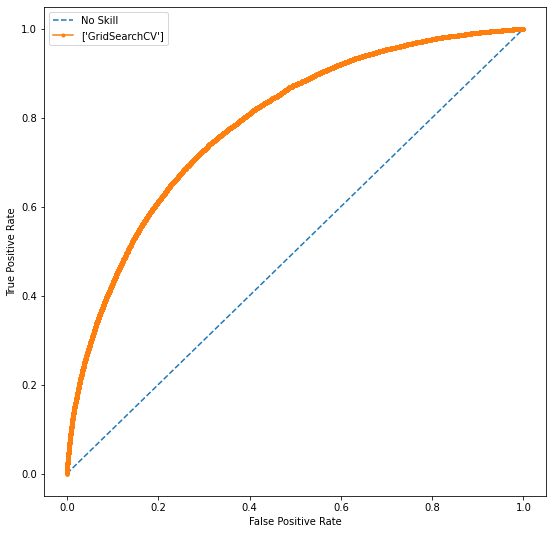

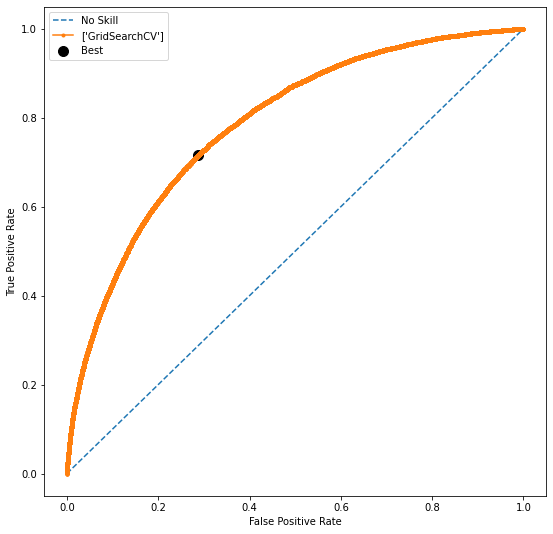

ROC-AUC score of the model: 0.7867209837134279
Accuracy of the model: 0.7124381084015236

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    813746
           1       0.04      0.72      0.07     12497

    accuracy                           0.71    826243
   macro avg       0.52      0.71      0.45    826243
weighted avg       0.98      0.71      0.82    826243


Confusion matrix: 
[[579695 234051]
 [  3545   8952]]



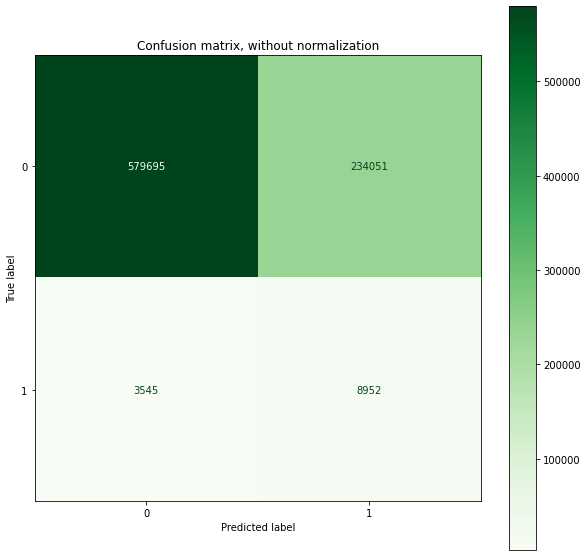

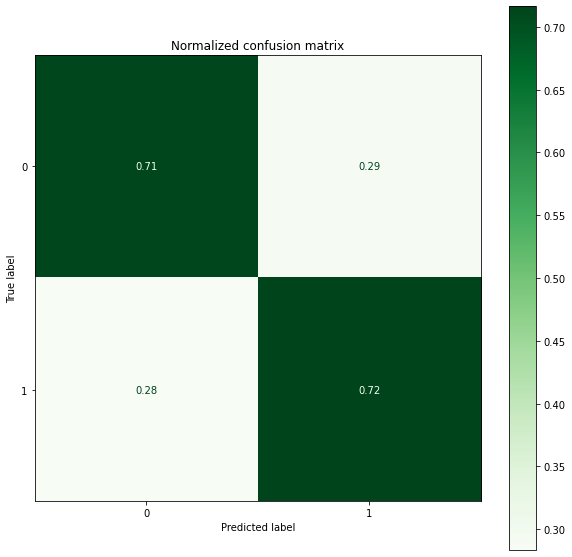

time: 12.8 s (started: 2022-06-08 13:46:30 +02:00)


In [44]:
model_analysis(CV,xtest,ytest)

### Ánalisis Modelo entrenado con datos reales

In [30]:
### cargar el Modelo
model_og = pickle.load(open('../models/lightgbm.joblib', 'rb'))

time: 1.47 ms (started: 2022-06-08 12:44:23 +02:00)


In [42]:
with open('../models/lightgbm.joblib', 'rb') as f:
    model_og = pickle.load(f)

time: 13.8 ms (started: 2022-06-08 13:46:10 +02:00)


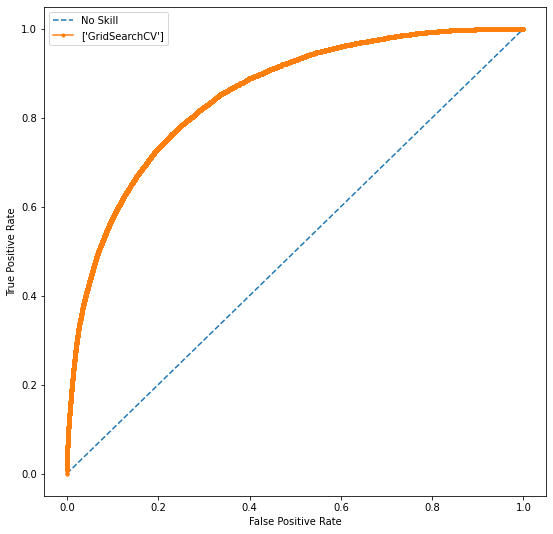

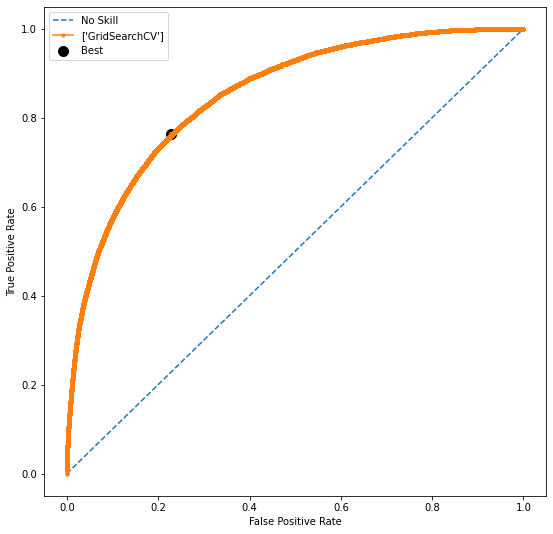

ROC-AUC score of the model: 0.8510720066284385
Accuracy of the model: 0.7710564567566685

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    813746
           1       0.05      0.76      0.09     12497

    accuracy                           0.77    826243
   macro avg       0.52      0.77      0.48    826243
weighted avg       0.98      0.77      0.86    826243


Confusion matrix: 
[[627553 186193]
 [  2970   9527]]



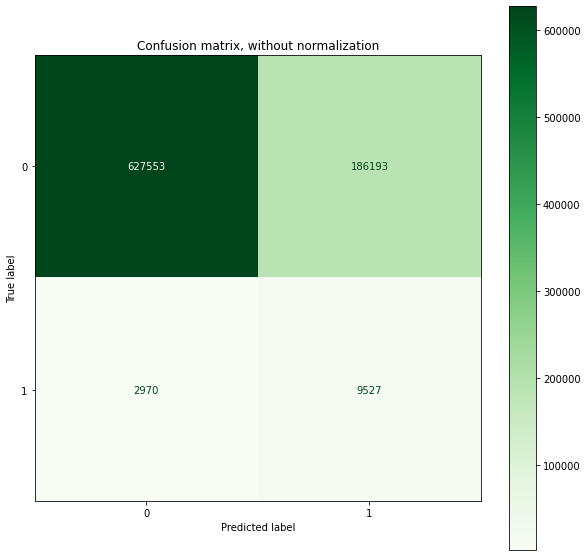

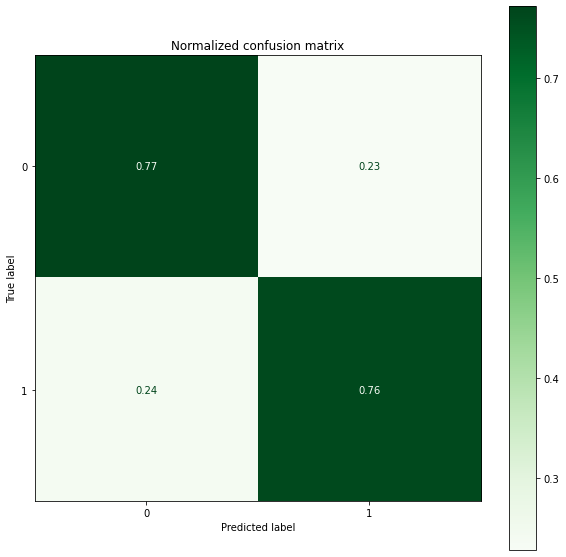

time: 11.3 s (started: 2022-06-08 13:46:12 +02:00)


In [43]:
model_analysis(model_og,xtest,ytest)